In [1]:
# python imports
from time import process_time
import matplotlib.pyplot as plt
import numpy as np

# Definitions

from sage.rings.padics.padic_generic import ResidueLiftingMap
from sage.rings.padics.padic_generic import ResidueReductionMap
import sage.rings.padics.padic_extension_generic

# Basic set-up
p = 3       # Choose the prime p to calculate with
precision = 1000 # Choose the precision that Sage will use

# Define the polynomial to adjoin a root from
Q_p = Qp(p,precision)
R_Qp.<x> = PolynomialRing(Q_p)
f_poly = x^2 - p

# Define the p-adic field, its ring of integers and its residue field
# These dummy objects are a workaround to force the precision wanted
dummy1.<y> = Zp(p).ext(f_poly)
dummy2.<y> = Qp(p).ext(f_poly)

o_L.<y> = dummy1.change(prec=precision)
L.<y> = dummy2.change(prec=precision)
k_L = L.residue_field()

# Find the generator of the unique maximal ideal in o_L. Needed for the vwdwo sequence
Pi = o_L.uniformizer()
unique_maximal = o_L.ideal(Pi)

# find f, e and q
f = k_L.degree()       # The degree of the residual field extension
e = L.degree()/k_L.degree()       # The ramification index
q = p^f

# constructs a lifting map from k_L to o_L to allow us to find representatives for the residue classes
dummy_func = ResidueLiftingMap._create_(k_L, o_L)
def k_L_to_o_L(x):
    return(L(dummy_func(x).lift_to_precision()))

# construct a full set of residues modulo m, the unique maximal ideal of o_L. needed for vwdwo sequence
residues = [k_L_to_o_L(x) for i,x in enumerate(k_L)]

# Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]

v = L.valuation()

# Decorator to record execution time
def time_this(func, name=None):
    if name is None:
        name = func.__name__
    
    
    def wrap(*args, **kwargs):
        _start = process_time()
        result = func(*args, **kwargs)
        _end   = process_time()
        
        print(f"{_end-_start : .2f} sec: {name}", end='\r')
        return result

    return wrap

# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns (roughly, S is (q-1)*Size), 
# then quickly populate it one row at a time, using the recursion formula.

def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m, D=None):
    if D is None:
        D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = time_this( lambda: R.inverse(), f"R^-1 for m={m}")()
    
    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

# Compute the matrix ( \sigma_{ij}(Y) ) using Proposition 10.6 of "bounded21":
def sigmaMatrix(Size):
    sigma = matrix(L_Y, Size,Size)
    
    for m in [0 .. q-2]:
        Tau = TauMatrix(ceil(Size/(q-1)), m)
        j = 0
        while underscore(m, j) < Size:
            i = 0
            while underscore(m, i) < Size:
                sigma[underscore(m, i), underscore(m, j)] = Y^m * Tau[i, j](Y^(q-1))
                i += 1000
            j += 1
    
    return sigma



In [2]:
def w_q(n):
    return (n - sum(n.digits(base=q))) / (q-1)

def n_data(N, filename=None):
    t_start = process_time()
    Size=N+1
    D = time_this(lambda: Dmatrix((q - 1) * (Size + 1)), "D matrix")()
    Taus = [ time_this(lambda: TauMatrix(N+1, m, D), f"Tau for m={m}")() for m in range(q-1) ]
    t_end = process_time()
    print(f"Tau for all m: {t_end-t_start : .2f} sec")
        
    data = [-1] * (N+1)*(q-1)
    
    for m in range(q-1):
        A_old = Matrix(0, 0)
        d = 0
        for n0 in range(N+1):
            t_start = process_time()
        
            # 1. Use the non-zero rows from previous calculations
            # 2. Add a 0 column to its left
            # 3. Add the corresponding rows from Tau for j=n0

            A = Matrix(L, 2*n0-d+1, n0-d+1)
            A[:n0-d, 1:] = A_old
            for i in range(n0+1):
                coeffs = Taus[m][i, n0].list()
                A[n0-d+i, A.ncols()-len(coeffs)+d:] = vector(L, reversed(coeffs[d:]))
                
            # Perform Gaussian elimination
            i_top = 0
            ks = []
            for k in range(A.ncols()):
                valuation_row_pairs = [ (v(A[i,k]), i) for i in range(i_top, A.nrows()) if A[i,k] != 0]

                # If we have a zero column, move on to the next one
                if not valuation_row_pairs:
                    continue
                minv, i_minv = min(valuation_row_pairs)
                ks.append(k)

                # Swap the row of minimum valuation with the top row
                A[i_top, :], A[i_minv, :] = A[i_minv, :], A[i_top, :]

                # Divide the top row by a unit in o_L
                a = A[i_top, k]
                mu = a / Pi^int(e * v(a))
                A[i_top, :] /= mu

                # Cleave through the other rows
                for i in range(A.nrows()):
                    if i != i_top and v(A[i, k]) >= v(A[i_top, k]):
                        A[i, :] -= A[i, k]/A[i_top, k] * A[i_top, :]

                i_top += 1
            
            d_set = False
            for n in range(d,n0+1):
                if v(A[n0-n, n0-n]) * e == -w_q(m + (q-1)*n): 
                    x = m + (q-1)*n
                    if data[x] == -1:
                        data[x] = n0
                else:
                    if not d_set:
                        d = n
                        d_set = True
            
            A_old = A[:n0-d+1, :n0-d+1]
            
            t_end = process_time()
            print(f"n0={n0}, m={m}: {t_end-t_start : .2f} sec", end='\r')
            if filename is not None:
                with open(filename, 'w') as f:
                    f.write("x, n0\n")
                    for x_, n0_ in enumerate(data):
                        f.write(f"{x_}, {n0_}\n")

    plt.style.use('bmh')
    fig = plt.figure(figsize=(15,6), dpi=200)
    for x, n0 in enumerate(data):
        if n0 != -1:
            n = x // (q-1)
            plt.plot(x, (n0-n), 'x', c='C0')
        else:
            plt.plot(x, 0, 'x', c='C1')
    plt.xlabel(r"$m + (q-1) \cdot n$")
    plt.ylabel("$n_0(n, m) - n$")
    plt.title(str(L))
    plt.minorticks_on()
    plt.grid(which='both')
    plt.grid(which='major', linestyle='-', c='grey')
    print()
    
    return data, fig


3-adic Unramified Extension Field in y defined by x^3 + 2*x + 1
Tau for all m:  1085.63 sec
n0=200, m=25:  6.56 secc
5-adic Unramified Extension Field in y defined by x^3 + x + 1
Tau for all m:  1234.95 sec
n0=100, m=123:  0.01 sec
7-adic Unramified Extension Field in y defined by x^3 + 2
Tau for all m:  756.42 sec
n0=30, m=341:  0.01 sec


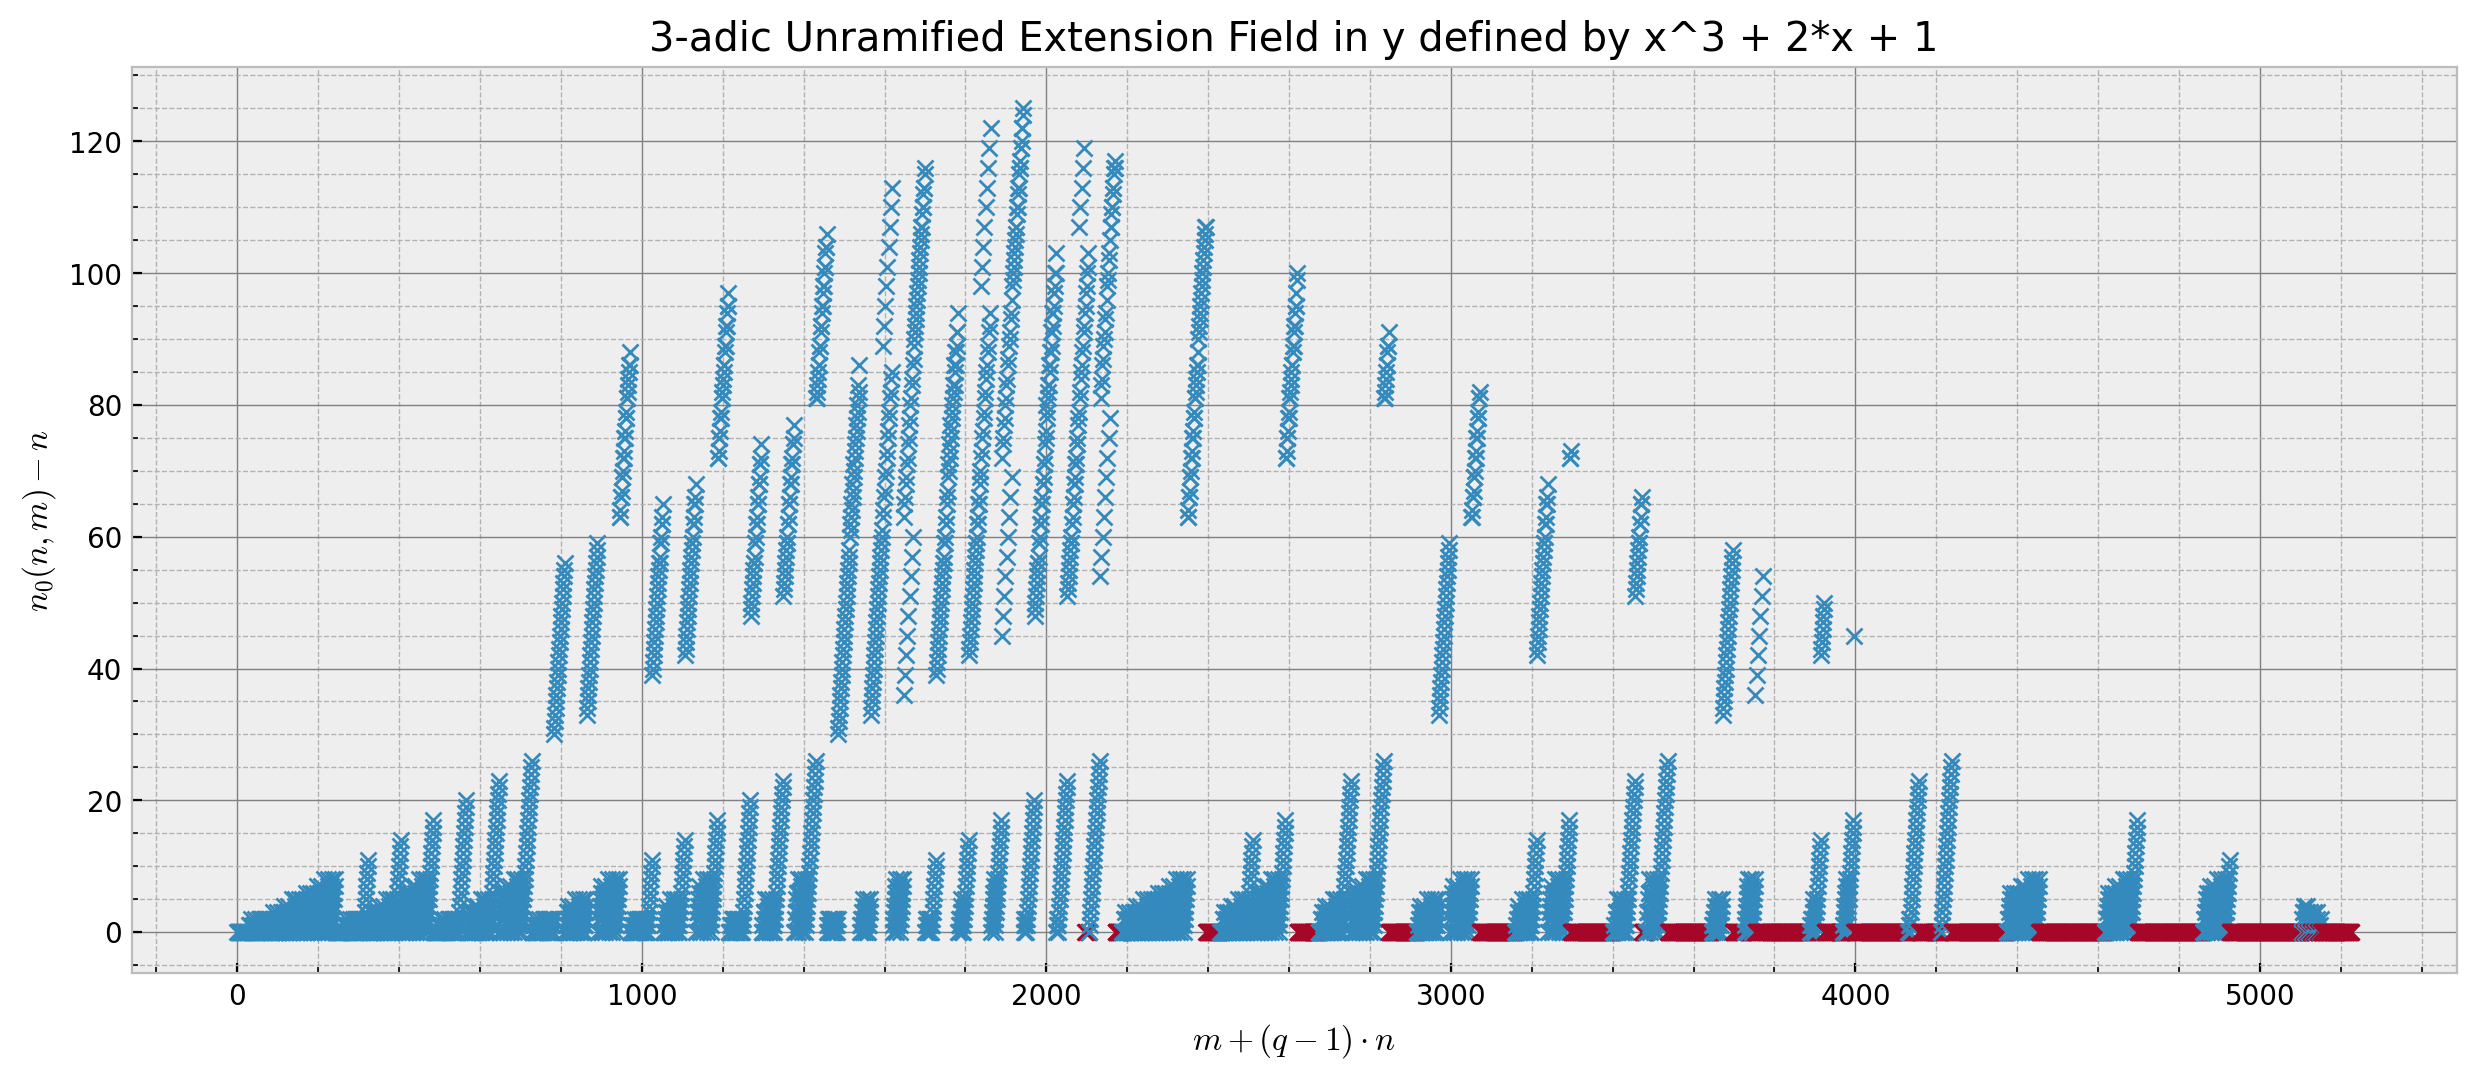

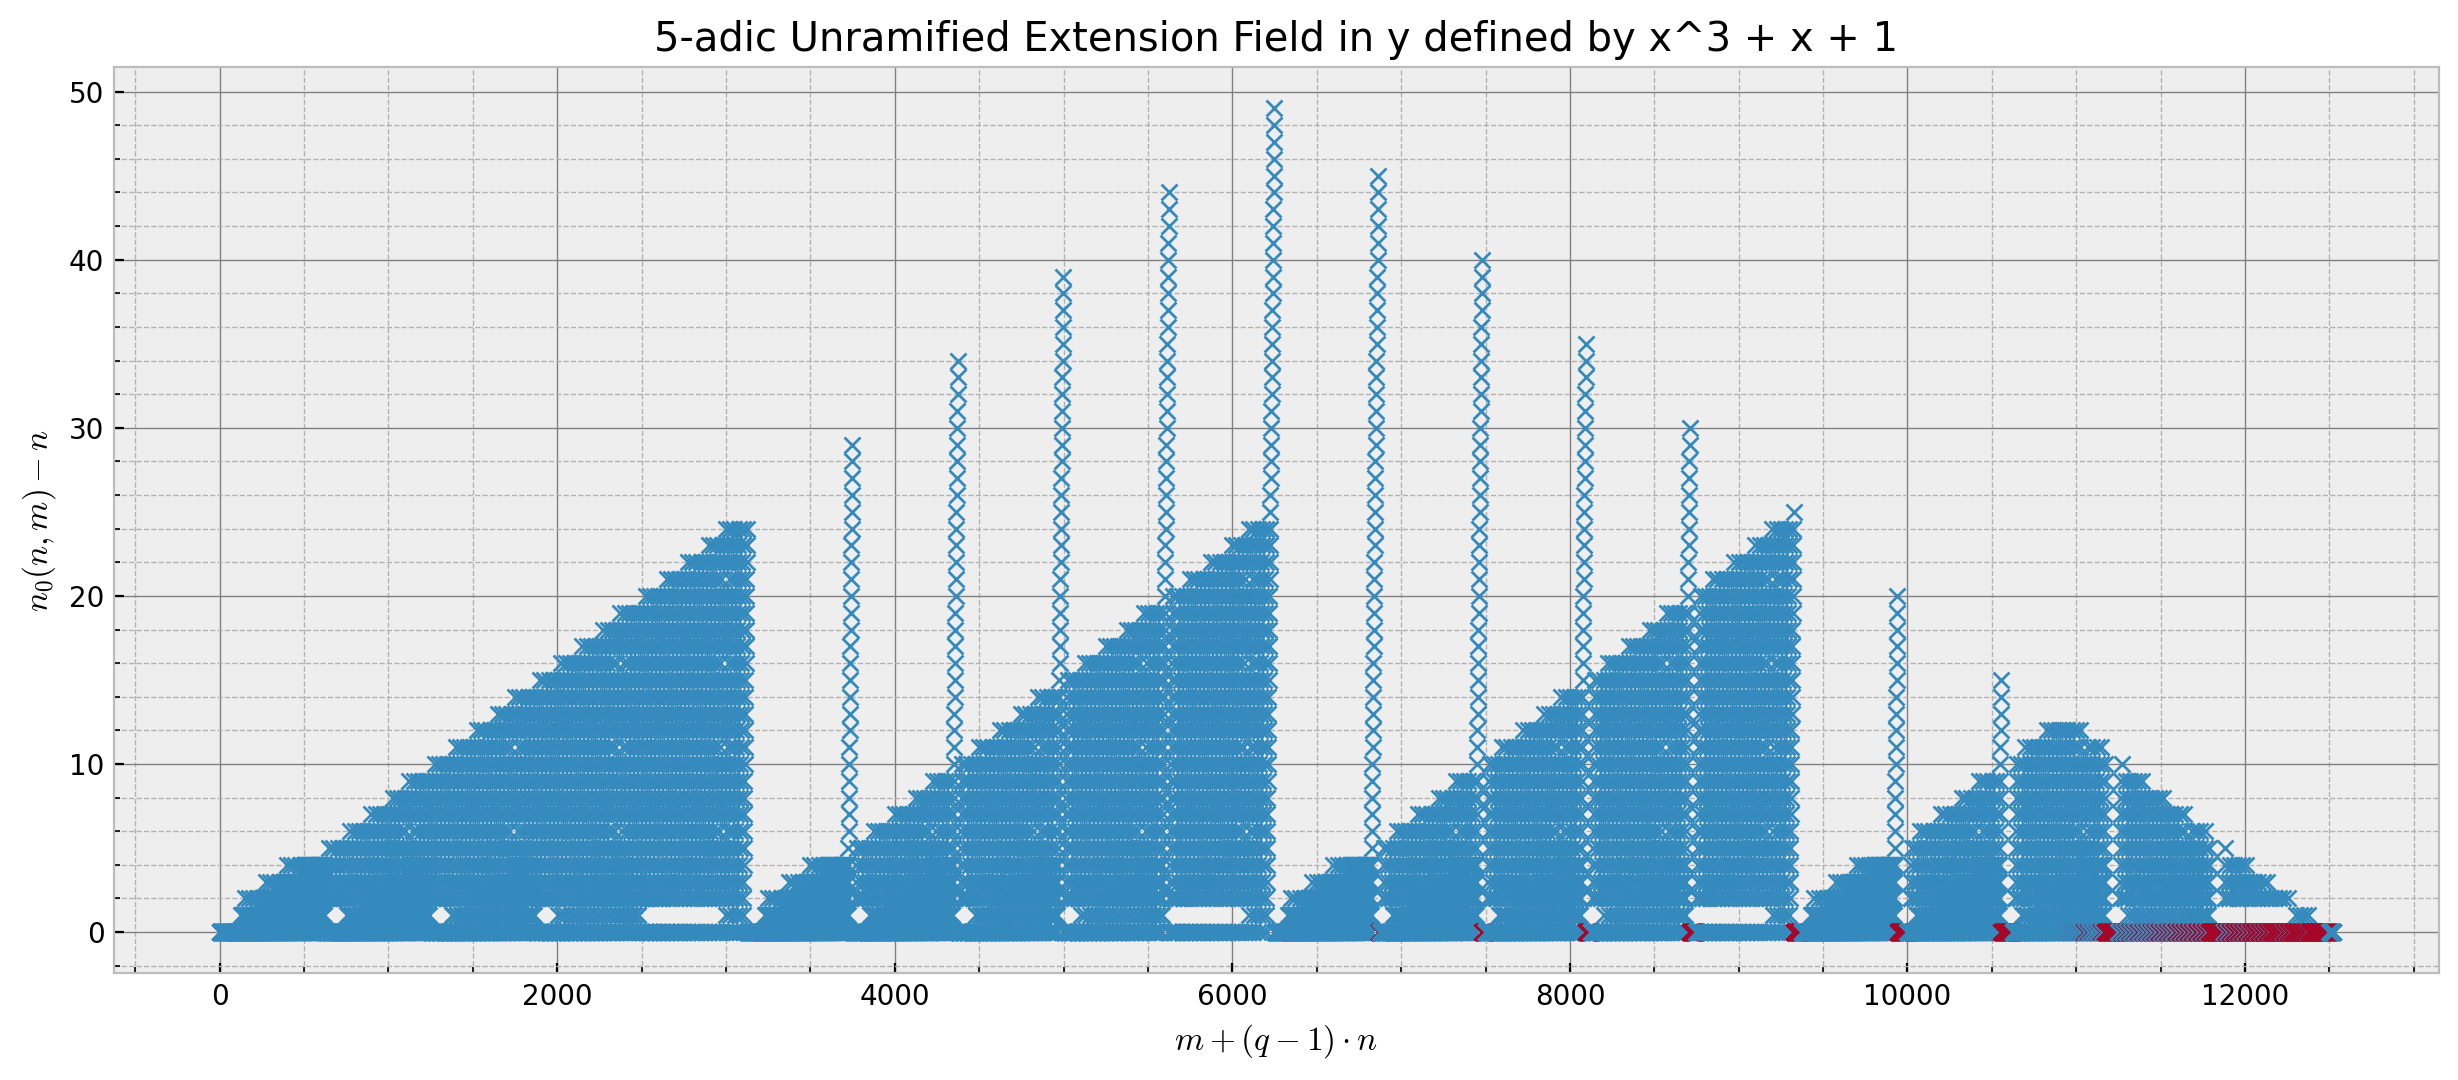

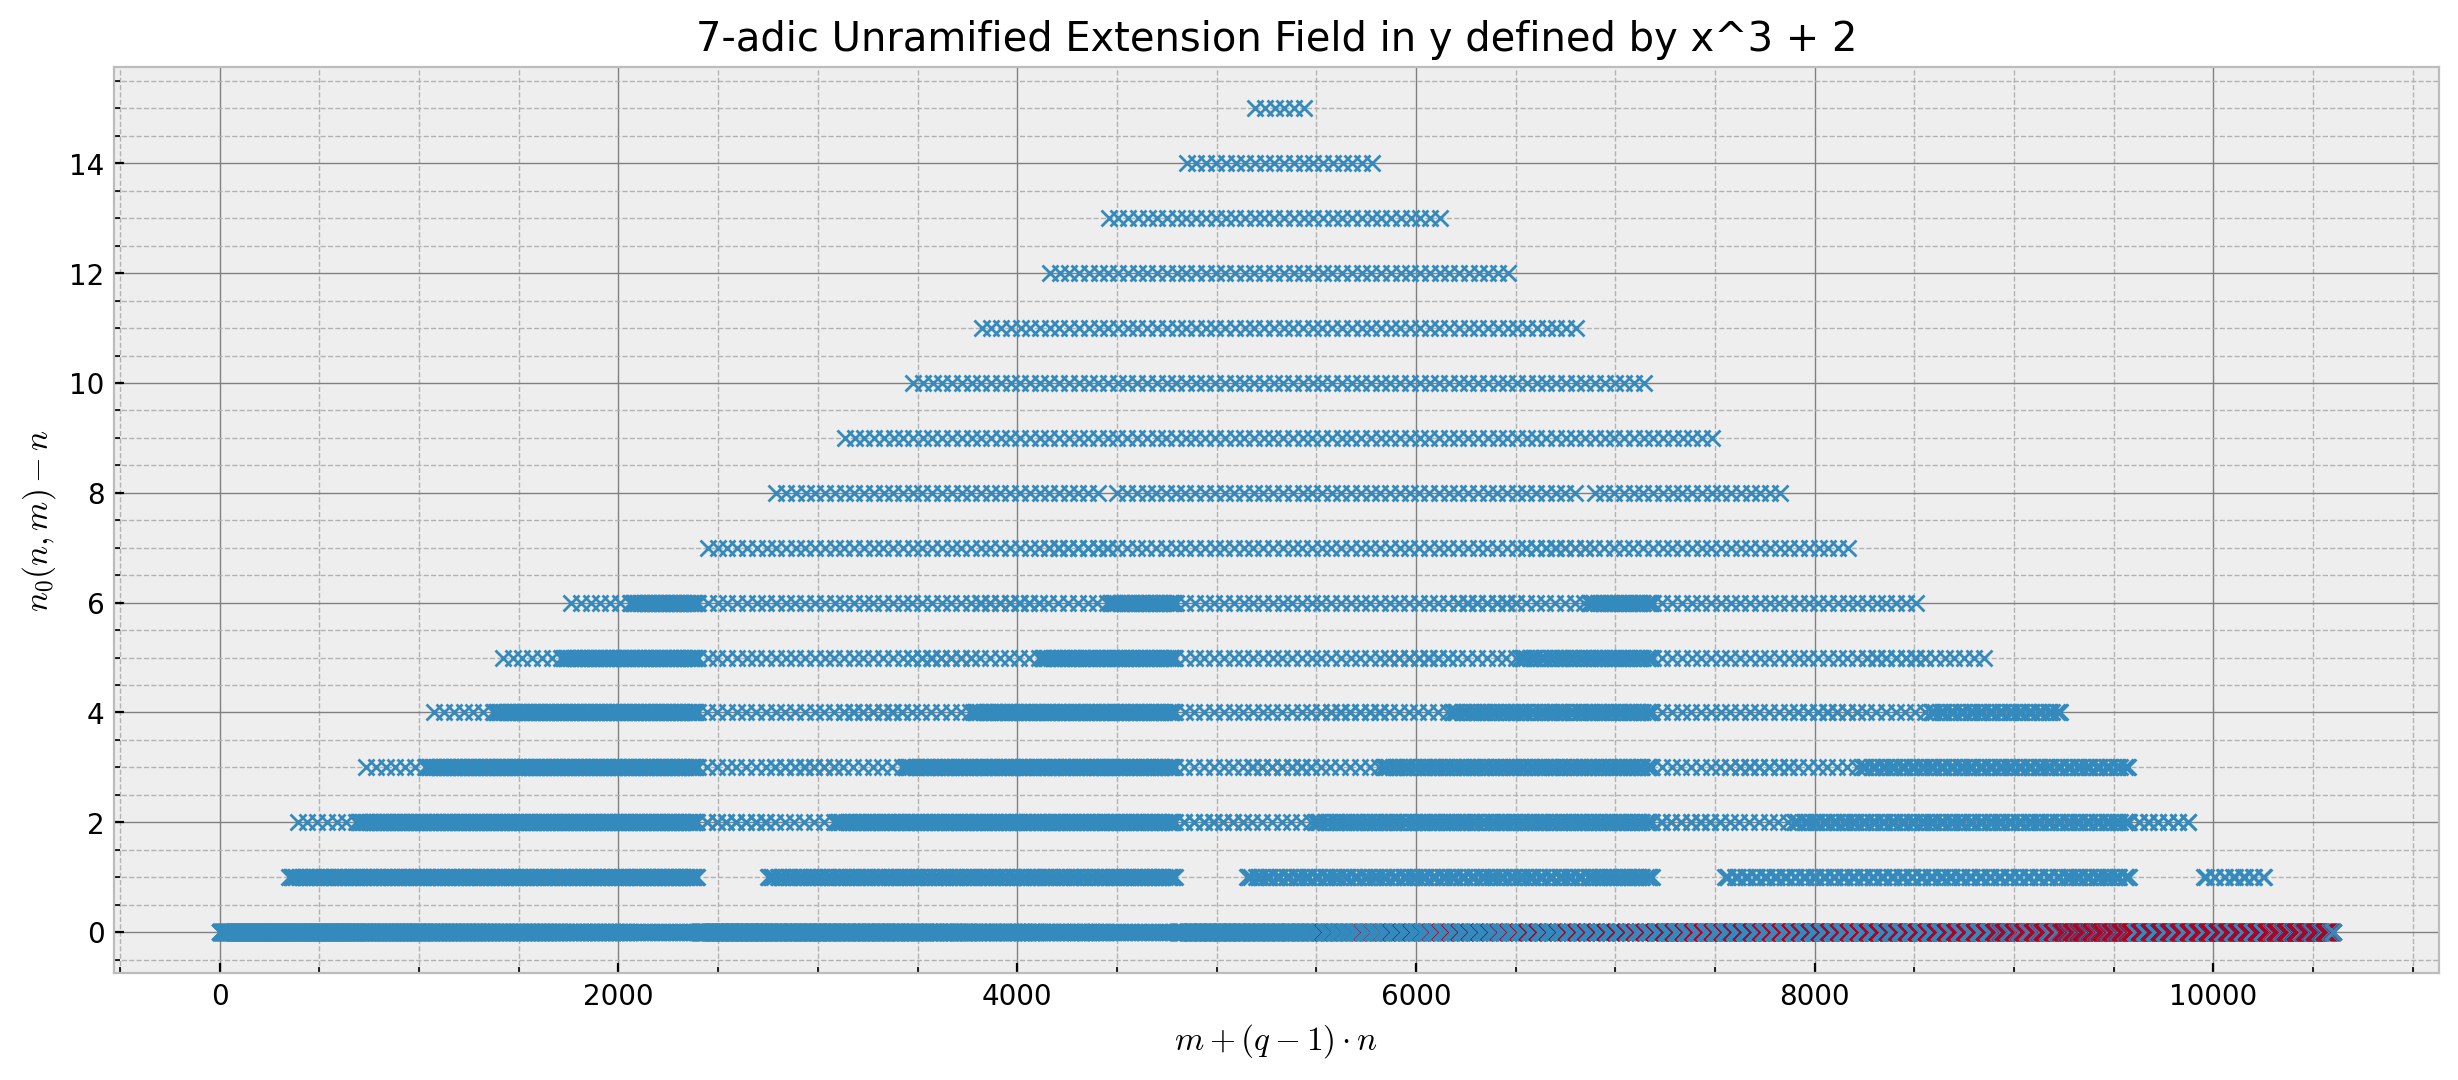

In [5]:
# WARNING
# makes directories in the directory you are working in

import os
import pathlib
import functools

run = []

with open("dragos_data2/run.txt") as f:
    while True:
        line = f.readline()
        if not line: break
        if line[0] != '#':
            run.append(line.rstrip())

        
for run_i in run:
    
    #check that this case hasnt been done before
    cwd = os.getcwd() + "/dragos_data2/" + str(run_i) + "/"
    
    if not os.path.isdir(cwd):
        # get basic info for the current case
        parse = run_i.split(',')
        p = int(parse[0])
        f = int(parse[1])
        big_N = int(parse[2])
        ram = parse[3]
        power = p^f - 1
        
        t_poly = ""
        
        if ram=="ram":
            t_poly = f"x^{f}-{p}"
        else:
            # generate poly for unramified case
            Fp = GF(p)
            Fp_t.<t> = PolynomialRing(Fp)
            unity_poly = t^(power) - 1
            factored = unity_poly.factor()
            factored_str = str(factored)
            start = factored_str.find("^"+str(f))
            last_brac_pos = factored_str.find(")",start)
            first_brac_pos = len(factored_str) - factored_str[::-1].find("(",len(factored_str)-start)
            t_poly = factored_str[first_brac_pos:last_brac_pos].replace('t','x')

        # Define the polynomial to adjoin a root from
        Q_p = Qp(p,precision)
        R_Qp.<x> = PolynomialRing(Q_p)
        f_poly = R_Qp(t_poly)

        # Define the p-adic field, its ring of integers and its residue field
        # These dummy objects are a workaround to force the precision wanted
        dummy1.<y> = Zp(p).ext(f_poly)
        dummy2.<y> = Qp(p).ext(f_poly)

        o_L.<y> = dummy1.change(prec=precision)
        L.<y> = dummy2.change(prec=precision)
        k_L = L.residue_field()
        print(L)

        # Find the generator of the unique maximal ideal in o_L. Needed for the vwdwo sequence
        Pi = o_L.uniformizer()
        unique_maximal = o_L.ideal(Pi)

        # find f, e and q
        f = k_L.degree()       # The degree of the residual field extension
        e = L.degree()/k_L.degree()       # The ramification index
        q = p^f

        # constructs a lifting map from k_L to o_L to allow us to find representatives for the residue classes
        dummy_func = ResidueLiftingMap._create_(k_L, o_L)
        def k_L_to_o_L(x):
            return(L(dummy_func(x).lift_to_precision()))

        # construct a full set of residues modulo m, the unique maximal ideal of o_L. needed for vwdwo sequence
        residues = [k_L_to_o_L(x) for i,x in enumerate(k_L)]

        # Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
        L_X.<X> = L[]
        L_Y.<Y> = L[]

        v = L.valuation()
        
        # make directory to output
        pathlib.Path(cwd).mkdir(parents=True, exist_ok=True)        
        
        # crunch TIME
        # writing data at the same time
        data, fig = n_data(big_N, filename=cwd+"data.txt")

        # output plots
        plt.savefig(cwd+"n0.png")
    